참고

https://luv-bansal.medium.com/fine-tuning-bert-for-text-classification-in-pytorch-503d97342db2,

https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [15]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import transformers
from transformers import BertTokenizer, BertModel
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np
import random
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

# GPU 할당

In [18]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터 준비

In [20]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [21]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [22]:
def make_input(df):
    sentences = df['문장'].tolist()
    input_ids =[]
    attention_masks =[]
    token_type_ids =[]
    for line in tqdm(sentences):
    #     line = ' '.join(mecab.morphs(line)) # mecab 적용, encode하면 tokenizer.tokenize 해준 것과 같은 결과 나옴
        encoded_dict = tokenizer.encode_plus(line, \
                                             add_special_tokens = True,\
                                             pad_to_max_length=True,\
                                             max_length=MAX_LENGTH, 
                                            return_attention_mask=True,
                                            truncation = True)

        input_id=encoded_dict['input_ids']
        attention_mask=encoded_dict['attention_mask']
        token_type_id = encoded_dict['token_type_ids']

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
    
    input_ids = torch.tensor(input_ids, dtype=torch.long).to(device)
    attention_masks = torch.tensor(attention_masks, dtype=torch.long).to(device)
    token_type_ids = torch.tensor(token_type_ids, dtype=torch.long).to(device)
    inputs = (input_ids, attention_masks, token_type_ids)

    # print("Original Text : ", sentences[0])
    # print("Tokenizer Text : ", tokenizer.tokenize(sentences[0]))
    # print("Encode Text : ", (tokenizer.encode(sentences[0], add_special_tokens = True, max_length=MAX_LENGTH)))
    
    return TensorDataset(input_ids, attention_masks, token_type_ids, torch.tensor(df['violence'].tolist(), dtype=torch.long).to(device))

In [23]:
def training(train_dataloader, validation_dataloader):
  # This training code is based on the `run_glue.py` script here:
  # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

  # Set the seed value all over the place to make this reproducible.
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  # We'll store a number of quantities such as training and validation loss, 
  # validation accuracy, and timings.
  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  # TensorDataset(input_ids, attention_masks, token_type_ids, torch.tensor(df['violence'].tolist(), dtype=torch.long).to(device))

  # For each epoch...
  for epoch_i in range(0, epochs):
      
      # ========================================
      #               Training
      # ========================================
      
      # Perform one full pass over the training set.

      # print("")
      # print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      # print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      # Put the model into training mode. Don't be mislead--the call to 
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 40 batches.
          if step % 50 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)
              
              # Report progress.
              # print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the 
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: token_type_ids
          #   [3]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_token_type_ids = batch[2].to(device)
          b_labels = batch[3].to(device)

          # Always clear any previously calculated gradients before performing a
          # backward pass. PyTorch doesn't do this automatically because 
          # accumulating the gradients is "convenient while training RNNs". 
          # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
          model.zero_grad()        

          # Perform a forward pass (evaluate the model on this training batch).
          # The documentation for this `model` function is here: 
          # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
          # It returns different numbers of parameters depending on what arguments
          # arge given and what flags are set. For our useage here, it returns
          # the loss (because we provided labels) and the "logits"--the model
          # outputs prior to activation.
          loss, logits = model(b_input_ids, 
                              token_type_ids=b_token_type_ids, 
  #                              token_type_ids=None, 
                              attention_mask=b_input_mask, 
                              labels=b_labels)

          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value 
          # from the tensor.
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)            
      
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(training_time))
          
      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      # print("")
      # print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables 
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in validation_dataloader:
          
          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using 
          # the `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: token_type_ids
          #   [3]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_token_type_ids = batch[2].to(device)
          b_labels = batch[3].to(device)
          
          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():        

              # Forward pass, calculate logit predictions.
              # token_type_ids is the same as the "segment ids", which 
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              # The documentation for this `model` function is here: 
              # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
              # Get the "logits" output by the model. The "logits" are the output
              # values prior to applying an activation function like the softmax.
              (loss, logits) = model(b_input_ids, 
                                    token_type_ids=b_token_type_ids, 
  #                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
              
          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)
          

      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(validation_dataloader)
      
      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)

      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))
      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

      print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  return training_stats

In [24]:
def training_stats(training_stats):
  # Display floats with two decimal places.
  pd.set_option('precision', 2)

  # Create a DataFrame from our training statistics.
  df_stats = pd.DataFrame(data=training_stats)

  # Use the 'epoch' as the row index.
  df_stats = df_stats.set_index('epoch')

  # A hack to force the column headers to wrap.
  #df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

  # Display the table.
  df_stats

In [25]:
def prediction():
  # Prediction on test set

  # print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []

  # Predict 
  for batch in test_dataloader:
      # Add batch to GPU
  #     batch = tuple(t.to(device) for t in batch)
      # print(batch)

      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_token_type_ids, b_labels = batch
      # print(b_input_ids)

      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(input_ids = b_input_ids, 
                          token_type_ids = b_token_type_ids, 
                          attention_mask = b_input_mask,
                          # labels = b_labels,
                          )

      logits = outputs[0]

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

  # print('    DONE.')

In [26]:
def test_prediction(test_dataloader):
  # Prediction on test set
  # Put model in evaluation mode
  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []

  # Predict 
  for batch in test_dataloader:
      # Add batch to GPU
      # batch = tuple(t.to(device) for t in batch)
      # print(batch)

      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_token_type_ids, b_labels = batch
      # print(b_input_ids)

      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(input_ids = b_input_ids, 
                          token_type_ids = b_token_type_ids, 
                          attention_mask = b_input_mask,
                          # labels = b_labels,
                          )

      logits = outputs[0]

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.cpu().numpy()

      # Store predictions and true labels
      for logit in logits:
          pred = np.argmax(logit)
          predictions.append(pred)

      for ids in label_ids:
          true_labels.append(ids)
  return true_labels, predictions

In [27]:
def result(true_labels, predictions):
  target_names = ['0', '1']
  print(classification_report(true_labels, predictions, target_names=target_names))

  # Build confusion matrix
  cf_matrix = confusion_matrix(true_labels, predictions)
  print(cf_matrix)

  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in target_names],
                     columns = [i for i in target_names])
  
  plt.figure(figsize = (12,7))
  sns.heatmap(df_cm, annot=True)

# here


Some weights of the model checkpoint at snunlp/KR-BERT-char16424 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkp

model : train_mecab.csv


  0%|          | 0/19436 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 6953/6953 [00:02<00:00, 2445.67it/s]


traning start

  Average training loss: 0.47
  Training epcoh took: 0:03:54
  Accuracy: 0.79
  Validation Loss: 0.43
  Validation took: 0:00:30
Total training took 0:04:24 (h:mm:ss)

  Average training loss: 0.36
  Training epcoh took: 0:03:53
  Accuracy: 0.80
  Validation Loss: 0.45
  Validation took: 0:00:30
Total training took 0:08:47 (h:mm:ss)

  Average training loss: 0.25
  Training epcoh took: 0:03:53
  Accuracy: 0.79
  Validation Loss: 0.54
  Validation took: 0:00:30
Total training took 0:13:10 (h:mm:ss)

  Average training loss: 0.19
  Training epcoh took: 0:03:53
  Accuracy: 0.79
  Validation Loss: 0.59
  Validation took: 0:00:30
Total training took 0:17:33 (h:mm:ss)
학습 데이터 예측 시작
test 예측 시작
test 예측 결과
              precision    recall  f1-score   support

           0       0.67      0.70      0.69      2297
           1       0.85      0.83      0.84      4656

    accuracy                           0.79      6953
   macro avg       0.76      0.77      0.76      6953
weighte

  0%|          | 0/19573 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 6992/6992 [00:02<00:00, 2979.05it/s]


traning start

  Average training loss: 0.37
  Training epcoh took: 0:03:55
  Accuracy: 0.85
  Validation Loss: 0.33
  Validation took: 0:00:30
Total training took 0:04:25 (h:mm:ss)

  Average training loss: 0.24
  Training epcoh took: 0:03:55
  Accuracy: 0.85
  Validation Loss: 0.36
  Validation took: 0:00:30
Total training took 0:08:50 (h:mm:ss)

  Average training loss: 0.14
  Training epcoh took: 0:03:55
  Accuracy: 0.85
  Validation Loss: 0.45
  Validation took: 0:00:30
Total training took 0:13:15 (h:mm:ss)

  Average training loss: 0.09
  Training epcoh took: 0:03:55
  Accuracy: 0.85
  Validation Loss: 0.55
  Validation took: 0:00:30
Total training took 0:17:41 (h:mm:ss)
학습 데이터 예측 시작
test 예측 시작
test 예측 결과
              precision    recall  f1-score   support

           0       0.70      0.71      0.71      2321
           1       0.86      0.85      0.85      4671

    accuracy                           0.80      6992
   macro avg       0.78      0.78      0.78      6992
weighte

  0%|          | 0/19529 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 6976/6976 [00:02<00:00, 3072.87it/s]


traning start

  Average training loss: 0.28
  Training epcoh took: 0:03:55
  Accuracy: 0.91
  Validation Loss: 0.24
  Validation took: 0:00:30
Total training took 0:04:25 (h:mm:ss)

  Average training loss: 0.16
  Training epcoh took: 0:03:54
  Accuracy: 0.91
  Validation Loss: 0.26
  Validation took: 0:00:30
Total training took 0:08:50 (h:mm:ss)

  Average training loss: 0.09
  Training epcoh took: 0:03:54
  Accuracy: 0.90
  Validation Loss: 0.37
  Validation took: 0:00:30
Total training took 0:13:14 (h:mm:ss)

  Average training loss: 0.06
  Training epcoh took: 0:03:54
  Accuracy: 0.90
  Validation Loss: 0.42
  Validation took: 0:00:30
Total training took 0:17:38 (h:mm:ss)
학습 데이터 예측 시작
test 예측 시작
test 예측 결과
              precision    recall  f1-score   support

           0       0.71      0.70      0.71      2311
           1       0.85      0.86      0.86      4665

    accuracy                           0.81      6976
   macro avg       0.78      0.78      0.78      6976
weighte

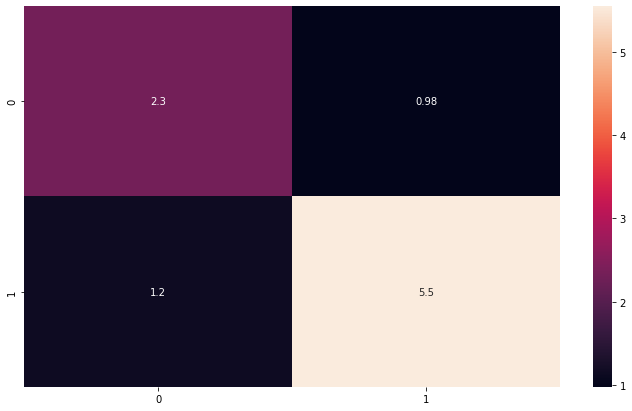

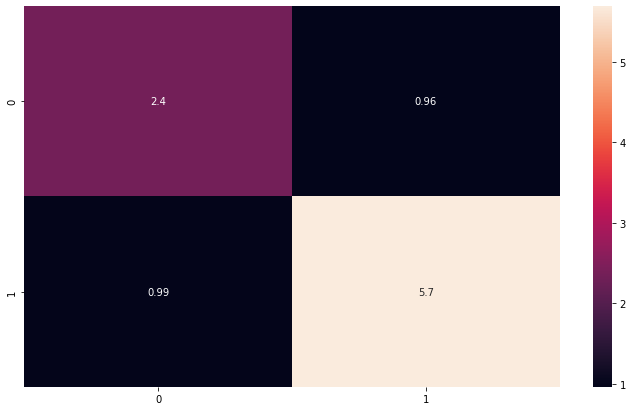

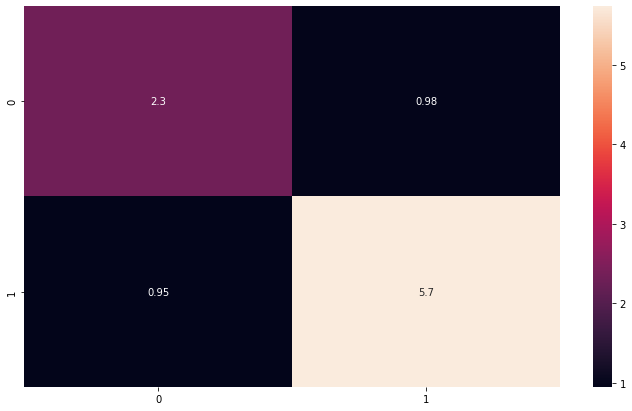

In [28]:
train_path = "/content/drive/MyDrive/NLP미니플젝-10조/태훈/코드/형태소분석기/data3/train/"
test_path = "/content/drive/MyDrive/NLP미니플젝-10조/태훈/코드/형태소분석기/data3/test/"

train_okt = "train_okt" + ".csv"
train_kkma = "train_kkma" + ".csv"
train_komoran = "train_komoran" + ".csv"
train_hannanum = "train_hannanum" + ".csv"
train_mecab = "train_mecab" + ".csv"
train_khaiii = "train_khaiii" + ".csv"
train_kiwi = "train_kiwi" + ".csv"

test_okt = "test_okt" + ".csv"
test_kkma = "test_kkma" + ".csv"
test_komoran = "test_komoran" + ".csv"
test_hannanum = "test_hannanum" + ".csv"
test_mecab = "test_mecab" + ".csv"
test_khaiii = "test_khaiii" + ".csv"
test_kiwi = "test_kiwi" + ".csv"

trains = [train_mecab, train_khaiii,train_kiwi]
tests = [test_mecab, test_khaiii,test_kiwi]

epo = 4 # 에폭
batch_size = 32 # 배치사이즈
MAX_LENGTH = 128


#model_name = "bert-base-uncased" # bert
model_name = "snunlp/KR-BERT-char16424" # kr-bert

tokenizer = BertTokenizer.from_pretrained(model_name)

model = BertForSequenceClassification.from_pretrained(
    model_name, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    return_dict = False,
)

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
epochs = epo

for i,j in zip(trains, tests):
  import torch, gc
  gc.collect()
  torch.cuda.empty_cache()
  
  print('model :' , i)
  train_data_path = train_path + i
  test_data_path = test_path + j
  df_train = pd.read_csv(train_data_path)
  df_test = pd.read_csv(test_data_path)

  df_train, df_valid = train_test_split(df_train, test_size=0.3, random_state=42)

  train_dataset = make_input(df_train)
  valid_dataset = make_input(df_valid)
  test_dataset = make_input(df_test)


  train_dataloader = DataLoader(
              train_dataset,  # The training samples.
              sampler = RandomSampler(train_dataset), # Select batches randomly
              batch_size = batch_size # Trains with this batch size.
          )
  validation_dataloader = DataLoader(
              valid_dataset, # The validation samples.
              sampler = SequentialSampler(valid_dataset), # Pull out batches sequentially.
              batch_size = batch_size # Evaluate with this batch size.
          )
  test_dataloader = DataLoader(
              test_dataset, # The validation samples.
              sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
              batch_size = batch_size # Evaluate with this batch size.
          )
  total_steps = len(train_dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)
  
  print('traning start')
  training_statss = training(train_dataloader, validation_dataloader)
  training_stats(training_statss)
  
  print('학습 데이터 예측 시작')
  prediction()
  print('test 예측 시작')
  true_labels, predictions = test_prediction(test_dataloader)
  print('test 예측 결과')
  result(true_labels, predictions)
  print('-'*50)
  print('-'*50)